# Imports

In [1]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data & OS utilities
import pandas as pd
import numpy as np
import os

# Constants
IMAGE_SIZE = 224
BATCH_SIZE = 32
base_path = '/kaggle/input/teethdataset/Teeth_Dataset'

# Preprocessing Data

## Loading Data

In [2]:
# Paths
train_dir = f'{base_path}/Training'
val_dir   = f'{base_path}/Validation'
test_dir  = f'{base_path}/Testing'

# Define only valid class folder names (change as needed)
valid_classes = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT'] 

# Custom ImageFolder that excludes unwanted folders
class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        all_classes = super().find_classes(directory)[0]
        classes = [cls for cls in all_classes if cls in valid_classes]
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Simple normalization to [-1, 1]
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset  = FilteredImageFolder(test_dir, transform=val_test_transforms)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes


# Class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Train Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")


Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Train Samples: 3087
Validation Samples: 1028
Test Samples: 1028


## Visualization

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


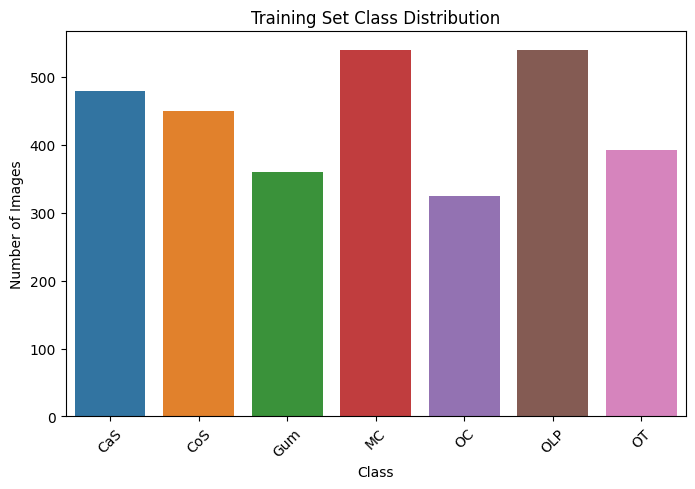

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


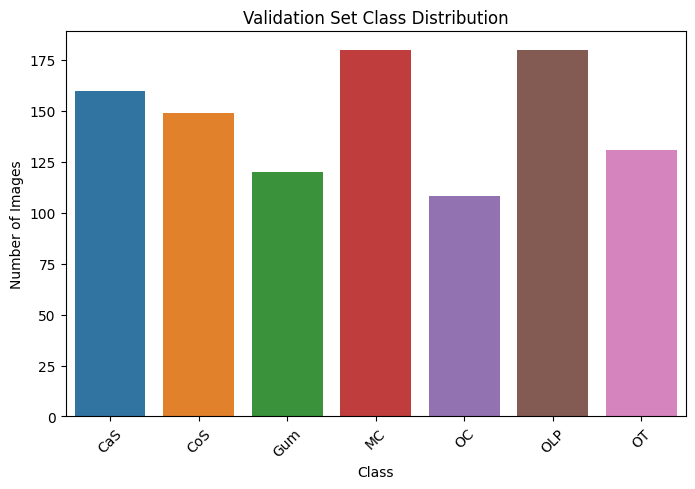

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


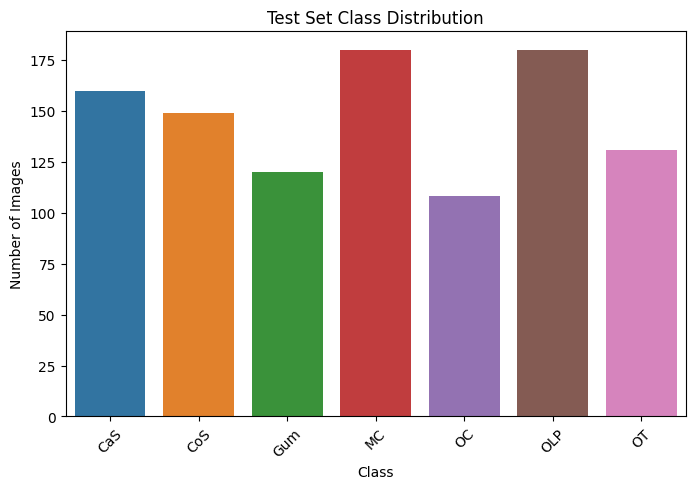

In [3]:
def plot_class_distribution(dataset, title):
    targets = [label for _, label in dataset]
    class_counts = pd.Series(targets).value_counts().sort_index()
    class_names_sorted = [class_names[i] for i in class_counts.index]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_names_sorted, y=class_counts.values)
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.xlabel("Class")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_dataset, "Training Set Class Distribution")
plot_class_distribution(val_dataset, "Validation Set Class Distribution")
plot_class_distribution(test_dataset, "Test Set Class Distribution")

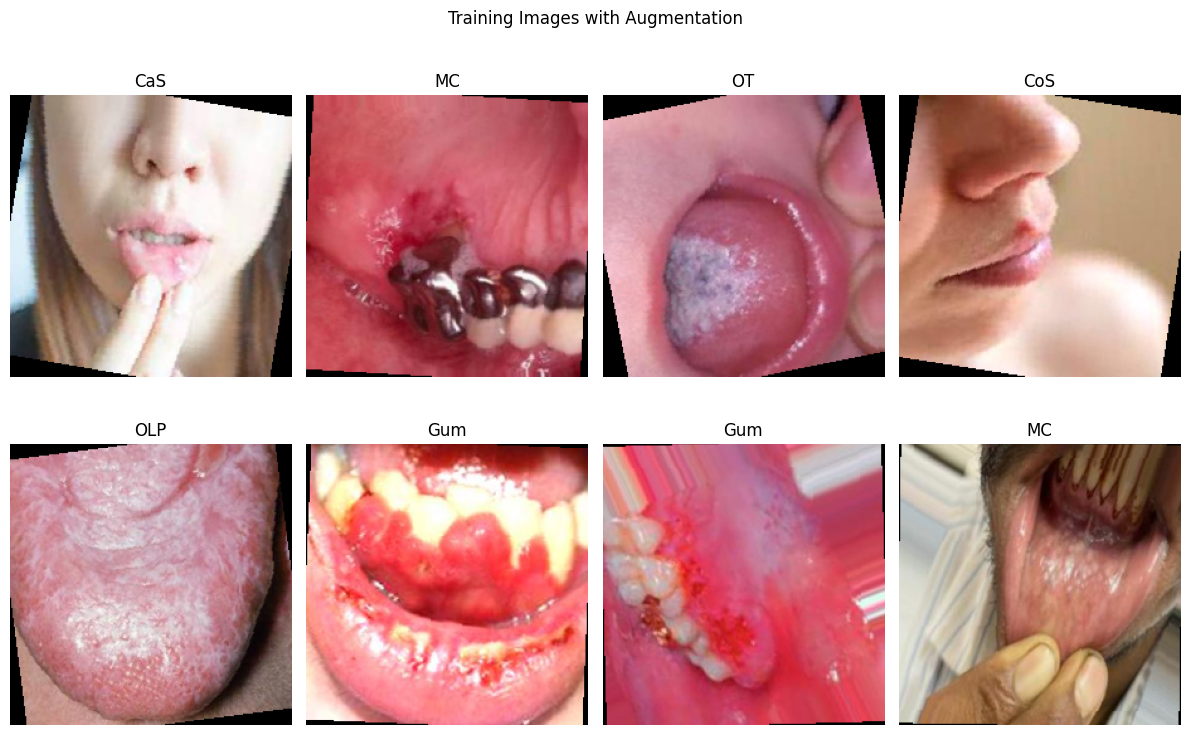

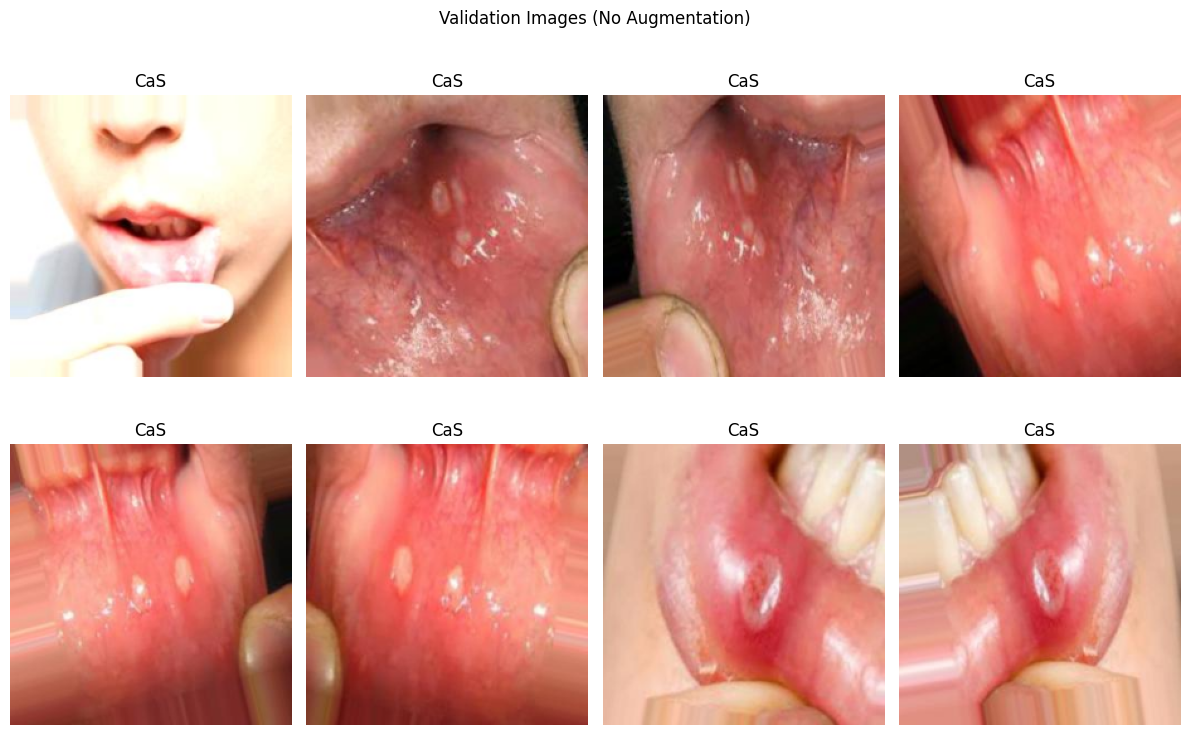

In [4]:
# Function to unnormalize and show image
def imshow(img_tensor, title=""):
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5  # Unnormalize from [-1, 1] to [0, 1]
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Visualize batch from train loader
def show_augmented_images(data_loader, title=""):
    images, labels = next(iter(data_loader))
    plt.figure(figsize=(12, 8))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        imshow(images[i], title=class_names[labels[i]])
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_augmented_images(train_loader, "Training Images with Augmentation")
show_augmented_images(val_loader, "Validation Images (No Augmentation)")


# Model and Training

In [5]:
class DentalCNN(nn.Module):
    def __init__(self, num_classes):
        super(DentalCNN, self).__init__()
        self.conv_block = nn.Sequential(
            # Block 1: 3 → 64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 112x112

            # Block 2: 64 → 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 56x56

            # Block 3: 128 → 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # [B, 256, 1, 1]
            nn.Flatten(),                  # [B, 256]
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DentalCNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [7]:
def train_model(model, train_loader, val_loader, epochs=30):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        val_acc = evaluate_model(model, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss:.4f}, Train Acc: {100*correct/total:.2f}%, Val Acc: {val_acc:.2f}%")


In [8]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total


In [9]:
train_model(model, train_loader, val_loader, epochs=30)

test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy (Baseline): {test_acc:.2f}%")


Epoch 1/30, Train Loss: 175.1426, Train Acc: 26.40%, Val Acc: 33.37%
Epoch 2/30, Train Loss: 163.2890, Train Acc: 32.65%, Val Acc: 27.82%
Epoch 3/30, Train Loss: 157.1840, Train Acc: 36.64%, Val Acc: 37.84%
Epoch 4/30, Train Loss: 154.7950, Train Acc: 37.93%, Val Acc: 42.51%
Epoch 5/30, Train Loss: 151.5652, Train Acc: 39.03%, Val Acc: 40.47%
Epoch 6/30, Train Loss: 145.5710, Train Acc: 40.72%, Val Acc: 41.54%
Epoch 7/30, Train Loss: 145.1750, Train Acc: 40.75%, Val Acc: 42.70%
Epoch 8/30, Train Loss: 142.0705, Train Acc: 43.28%, Val Acc: 44.07%
Epoch 9/30, Train Loss: 139.8550, Train Acc: 43.44%, Val Acc: 46.01%
Epoch 10/30, Train Loss: 137.2785, Train Acc: 45.16%, Val Acc: 47.86%
Epoch 11/30, Train Loss: 132.7421, Train Acc: 46.42%, Val Acc: 44.55%
Epoch 12/30, Train Loss: 133.9988, Train Acc: 46.68%, Val Acc: 50.49%
Epoch 13/30, Train Loss: 128.8387, Train Acc: 48.82%, Val Acc: 51.36%
Epoch 14/30, Train Loss: 127.7552, Train Acc: 48.17%, Val Acc: 50.19%
Epoch 15/30, Train Loss: 125.

In [10]:
train_model(model, train_loader, val_loader, epochs=30)

test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy (Baseline): {test_acc:.2f}%")

Epoch 1/30, Train Loss: 88.8988, Train Acc: 65.31%, Val Acc: 71.60%
Epoch 2/30, Train Loss: 85.4671, Train Acc: 67.35%, Val Acc: 70.04%
Epoch 3/30, Train Loss: 85.7058, Train Acc: 66.34%, Val Acc: 69.84%
Epoch 4/30, Train Loss: 84.7970, Train Acc: 66.28%, Val Acc: 70.91%
Epoch 5/30, Train Loss: 80.2498, Train Acc: 68.03%, Val Acc: 75.58%
Epoch 6/30, Train Loss: 77.2887, Train Acc: 70.20%, Val Acc: 74.22%
Epoch 7/30, Train Loss: 79.6658, Train Acc: 68.61%, Val Acc: 74.81%
Epoch 8/30, Train Loss: 78.4255, Train Acc: 69.94%, Val Acc: 75.19%
Epoch 9/30, Train Loss: 75.3305, Train Acc: 71.36%, Val Acc: 76.26%
Epoch 10/30, Train Loss: 74.3125, Train Acc: 71.17%, Val Acc: 76.46%
Epoch 11/30, Train Loss: 70.3953, Train Acc: 72.69%, Val Acc: 70.91%
Epoch 12/30, Train Loss: 74.3374, Train Acc: 71.30%, Val Acc: 70.23%
Epoch 13/30, Train Loss: 71.2727, Train Acc: 73.24%, Val Acc: 77.82%
Epoch 14/30, Train Loss: 69.6815, Train Acc: 73.11%, Val Acc: 78.89%
Epoch 15/30, Train Loss: 67.7541, Train Acc

In [11]:
train_model(model, train_loader, val_loader, epochs=30)

test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy (Baseline): {test_acc:.2f}%")

Epoch 1/30, Train Loss: 52.1141, Train Acc: 80.37%, Val Acc: 80.93%
Epoch 2/30, Train Loss: 49.7174, Train Acc: 81.44%, Val Acc: 85.89%
Epoch 3/30, Train Loss: 49.2031, Train Acc: 81.83%, Val Acc: 84.73%
Epoch 4/30, Train Loss: 46.1413, Train Acc: 82.51%, Val Acc: 87.16%
Epoch 5/30, Train Loss: 46.8074, Train Acc: 83.25%, Val Acc: 82.30%
Epoch 6/30, Train Loss: 43.5014, Train Acc: 84.03%, Val Acc: 86.77%
Epoch 7/30, Train Loss: 46.3601, Train Acc: 83.19%, Val Acc: 85.99%
Epoch 8/30, Train Loss: 45.5522, Train Acc: 83.71%, Val Acc: 88.13%
Epoch 9/30, Train Loss: 47.5575, Train Acc: 82.25%, Val Acc: 87.74%
Epoch 10/30, Train Loss: 44.8866, Train Acc: 83.71%, Val Acc: 89.88%
Epoch 11/30, Train Loss: 42.1387, Train Acc: 84.45%, Val Acc: 86.96%
Epoch 12/30, Train Loss: 41.2220, Train Acc: 85.13%, Val Acc: 83.46%
Epoch 13/30, Train Loss: 42.8075, Train Acc: 83.87%, Val Acc: 88.81%
Epoch 14/30, Train Loss: 43.9029, Train Acc: 84.06%, Val Acc: 91.44%
Epoch 15/30, Train Loss: 41.5214, Train Acc